In [1]:
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2022-12-04 11:46:58.477093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [4]:
#installing a dependency which whol be used to preprocess Bert inputs
!pip install tensorflow-text

  Using cached tensorflow-2.11.0-cp39-cp39-macosx_10_14_x86_64.whl (244.3 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.10.0
    Uninstalling tensorflow-2.10.0:
      Successfully uninstalled tensorflow-2.10.0


In [6]:
!pip install tf-models-official 

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *
 
    
np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.11.0


In [32]:
#read in labeled data for trainig model and drop unnecessary columns 
df = pd.read_csv('labeled_data.csv',nrows=None)
df['category'] = df['class'].map({0:'hate_speech', 1:'offensive_language', 2:'neither'})
df.rename(columns={'tweet':'text',
                  'class': 'label'},inplace=True)
print(df.columns)
df.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',],axis=1,inplace=True)
df.head()

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'label', 'text', 'category'],
      dtype='object')


,label,text,category
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [90]:
df[['label','text']].values.shape

(24783, 2)

In [50]:
from sklearn.model_selection import train_test_split
#Split data in train, test, validation 
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

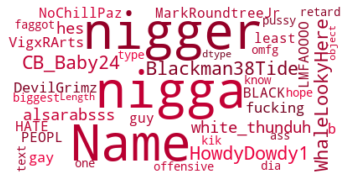

In [36]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="hate_speech"].text))
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

In [51]:
#Build input for Tensor flow
train_ds = tf.data.Dataset.from_tensor_slices((df.loc[X_train].text.values, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((df.loc[X_val].text.values,y_val))
test_ds = tf.data.Dataset.from_tensor_slices((df.loc[X_test].text.values,y_test))

In [52]:
#use drop_remainder to ignore the last batch to gett the full shape propagation
train_ds = train_ds.shuffle(len(X_train) + len (y_train)).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(len(X_val) + len(y_val)).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(X_test) + len(y_val)).batch(32, drop_remainder=False)

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [53]:
#Load models for Tensor flow 
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [54]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [55]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b"' You gottttta be a mad a madddd niggah &#1041204;&#1041204;&#1041204; Sayin ma name ? I must've got you madddddd niggah &#1041204;&#1041204;&#1041204;&#1041204;&#1041210;&#1041210;&#1041210;&#1043359;&#9995;"
Label : 1
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1005  2017  2288  4779  5946  2022  1037  5506  1037  5506 14141]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [57]:
# Using bert model on preprocessed data
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.6436605   0.6748428  -0.07993704  0.6079498   0.6100295   0.5450026
  0.99119055 -0.9359221  -0.4329195  -0.98398983 -0.17169055 -0.51072073]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.94555914  0.6429653  -0.32328534 ...  0.30440587  0.1567232
   0.31030113]
 [ 0.3333363  -0.71027845 -0.9163292  ...  1.5477345   0.5126611
  -0.01499371]
 [ 0.02261916  0.28246498  0.34899843 ... -0.18397747 -0.10727455
  -0.04464737]
 ...
 [-0.11290254  0.3199691   0.399507   ...  0.1221769   0.09426565
  -0.18713616]
 [ 0.6721483   0.45643547 -0.17790718 ... -0.14820117 -0.5486545
   0.34179598]
 [ 0.3212583   0.46208376  0.49320656 ... -0.61955225  0.09371249
  -1.1113169 ]]


In [63]:
#set class weights to deal with unbalanced 
hate = len(df[df['label']==0])
offensive = len(df[df['label']==1])
neither = len(df[df['label']==2])

total = len(df)

weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / offensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


In [64]:
initial_output_bias = np.array([3.938462, 15, 5.])
initial_output_bias 

array([ 3.938462, 15.      ,  5.      ])

In [65]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

In [66]:
classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5000058  0.7310409  0.50001675]], shape=(1, 3), dtype=float32)


In [67]:
classifier_model.get_weights()[-1]

array([ 3.938462, 15.      ,  5.      ], dtype=float32)

In [68]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [69]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [70]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [71]:
epochs = 80
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [72]:
#  classifier_model.compile(optimizer=optimizer,
#                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                           metrics=['accuracy'])
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [73]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/80


/Users/edinamklutse/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


628/628 [==============================] - 1822s 3s/step - loss: 3.6645 - accuracy: 0.7033 - val_loss: 0.9929 - val_accuracy: 0.5110
Epoch 2/80
628/628 [==============================] - 1846s 3s/step - loss: 0.9100 - accuracy: 0.7016 - val_loss: 0.5680 - val_accuracy: 0.8059
Epoch 3/80
628/628 [==============================] - 2429s 4s/step - loss: 0.6706 - accuracy: 0.8009 - val_loss: 0.5845 - val_accuracy: 0.7781
Epoch 4/80
628/628 [==============================] - 1874s 3s/step - loss: 0.5510 - accuracy: 0.8299 - val_loss: 0.3536 - val_accuracy: 0.8588
Epoch 5/80
628/628 [==============================] - 1811s 3s/step - loss: 0.4953 - accuracy: 0.8494 - val_loss: 0.5084 - val_accuracy: 0.7916
Epoch 6/80
628/628 [==============================] - 1763s 3s/step - loss: 0.4377 - accuracy: 0.8679 - val_loss: 0.2881 - val_accuracy: 0.9027
Epoch 7/80
628/628 [==============================] - 1845s 3s/step - loss: 0.3669 - accuracy: 0.8849 - val_loss: 0.5550 - val_accuracy: 0.7866
Epo

In [74]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 67s 854ms/step - loss: 1.1397 - accuracy: 0.9104
Loss: 1.1397281885147095
Accuracy: 0.9104477763175964


In [77]:
result =  classifier_model.predict(test_ds)
print(np.argmax(result,axis=-1))

78/78 [==============================] - 67s 858ms/step
[1 1 2 ... 1 1 1]


In [79]:
classifier_model.save('Bert_MLP_TF_Hate_Speech_Classification_Model',include_optimizer=False)

In [20]:
classifier_model = tf.keras.models.load_model('Bert_MLP_TF_Hate_Speech_Classification_Model')

In [7]:
NBA_tweets = pd.read_csv('NBA_tweets_snscrape.csv',)
NBA_tweets.drop(NBA_tweets.columns[0], axis = 1, inplace= True )
NBA_tweets.head()

/Users/edinamklutse/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tweets
0,Precious Achiuwa block Kevin Durant come dey b...
1,@2great2fail Nigga just because someone knows ...
2,Nigga just listing players who sounds like tha...
3,Niggas will do this and at the same time say B...
4,Niggas who only watch conference finals and Bo...


In [85]:
NBA_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027717 entries, 0 to 1027716
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  503424 non-null  object
dtypes: object(1)
memory usage: 7.8+ MB


In [8]:
NBA_tweets_mat = NBA_tweets['tweets'].astype(str).values
NBA_tweets_mat.reshape((1027717,1))
NBA_tweets_mat                       

array(['Precious Achiuwa block Kevin Durant come dey believe himself.\nNigger legit ducked when he saw Lebron James coming at him 😂',
       '@2great2fail Nigga just because someone knows how to play basketball really well that doesn’t mean they ain’t wrong on a basketball opinion lmfao LeBron absolutely clears Kobe and putting Kobe above Mj makes literally zero sense he does nothing better other than shoot the 3',
       'Nigga just listing players who sounds like that would be true cuz one thing about Jimmy is he def better I’m the playoffs than regular season 😂 https://t.co/nT49LCOz6W',
       ...,
       "Red Kelly's honorary pallbearers include Frank Mahovlich, Bob Baun, Ron Ellis, Dave Keon, Lanny McDonald, Darryl Sittler, Eddie Shack, Dick Duff, and Jim Gregory. #NHL #tmltalk #redkelly #LeafsForever #Leafs https://t.co/GiRdTkV5MU",
       'John Ferguson scored his 100th career goal as Canadiens and Maple Leafs  battled to a 1-1 tie in Toronto. Mickey Redmond, Dick Duff and Jacqu

In [22]:
pred_NBA=classifier_model.predict(NBA_tweets_mat)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32117/32117 [==============================] - 30940s 963ms/step


In [23]:
NBA_tweets['label']=np.argmax(pred_NBA,axis=-1)
NBA_tweets['category']=NBA_tweets['label'].map({0:'hate_speech', 1:'offensive_language', 2:'neither'})
NBA_hate_tweets = NBA_tweets[NBA_tweets['label']==0]
NBA_hate_tweets.head()


,tweets,label,category
0,Precious Achiuwa block Kevin Durant come dey b...,0,hate_speech
7,it's always the weak ass niggas who hurt our s...,0,hate_speech
12,Precious Achiuwa is balling this nigga Embiid ...,0,hate_speech
180,@Dolgo13 Dynamic Duo they said we was the Roma...,0,hate_speech
228,it's always the weak ass niggas who hurt our s...,0,hate_speech


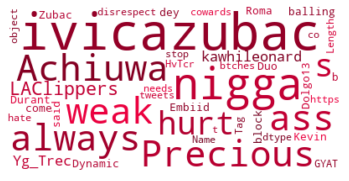

In [26]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(NBA_hate_tweets.loc[NBA_hate_tweets["category"]=="hate_speech"].tweets))
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

In [27]:
NBA_tweets.to_csv("Bert_Classified_NBA_tweets",sep=',')

In [28]:
NBA_hate_tweets.to_csv("Bert_Classified_NBA_hate_tweets",sep=',')

In [30]:
NBA_hate_tweets.head(100)

,tweets,label,category
0,Precious Achiuwa block Kevin Durant come dey b...,0,hate_speech
7,it's always the weak ass niggas who hurt our s...,0,hate_speech
12,Precious Achiuwa is balling this nigga Embiid ...,0,hate_speech
180,@Dolgo13 Dynamic Duo they said we was the Roma...,0,hate_speech
228,it's always the weak ass niggas who hurt our s...,0,hate_speech
...,...,...,...
1196,bro steven adams is such a good cunt https://t...,0,hate_speech
1209,@rickygervais @_stevenadams Ugh Steven Adams y...,0,hate_speech
1219,Steven adams is an asshole,0,hate_speech
1220,@cityofokc @RealStevenAdams Screw Presti. I'm ...,0,hate_speech
